In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 1. Prepare data as dataframe:
data = pd.read_csv("AB_NYC_2019.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
#2. Apply Label Encoding for Categorical Data

from sklearn.preprocessing import LabelEncoder
# Apply label encoding to 'neighbourhood_group' and 'room_type'
le=LabelEncoder()
data['group_encoded']=le.fit_transform(data['neighbourhood_group'])
data['room_type']=le.fit_transform(data['room_type'])

# Calculate mean price for each neighborhood_group and neighborhood combination
grouped = data.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean()
mapping_dict = grouped.to_dict()

# Replace neighborhood column with mean prices
data['neighbourhood_encoded'] = data.apply(lambda x: mapping_dict.get((x['neighbourhood_group'], x['neighbourhood']), np.nan), axis=1)


In [6]:
#3. Calculate recency of last_review based on date-time column in source dataset

data['last_review'] = pd.to_datetime(data['last_review'])
last_day_of_2019 = pd.Timestamp(year=2019, month=12, day=31)
data['recency'] = np.log((last_day_of_2019 - data['last_review']).dt.days)

In [7]:
# 4. Replace neighborhood column with price range
grouped_1 = data.groupby(['neighbourhood_group', 'neighbourhood'])['price'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
mapping_dict_1 = grouped_1.to_dict()

data['group_range'] = data.apply(lambda x: mapping_dict_1.get((x['neighbourhood_group'], x['neighbourhood']), np.nan), axis=1)

In [8]:
# 5. Remove columns assessed not to affect results
new_data=data.drop(['id','host_name','name','neighbourhood_group','neighbourhood','last_review'],axis=1)
new_data=new_data[new_data['price']!=0]

In [9]:
# 6. Select only the numerical columns for normalization

from sklearn.preprocessing import StandardScaler
numerical_cols = new_data.select_dtypes(include=['int64','float64']).drop(['room_type', 'price','group_encoded'], axis=1).columns.tolist()
# Normalize the numerical columns using StandardScaler
scaler = StandardScaler()
new_data[numerical_cols] = scaler.fit_transform(new_data[numerical_cols])

In [10]:
# 7. Drop columns with na values:
new_data['price']=np.log(new_data['price'])
new_data = new_data.dropna()

In [11]:
# 8. View cleaned data
new_data.head()

,host_id,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,group_encoded,neighbourhood_encoded,recency,group_range
0,-0.860122,-1.493872,-0.437504,1,5.003946,-0.293969,-0.320353,-0.692186,-0.034732,1.916192,1,-0.960600,0.372359,-0.984067
1,-0.860121,0.452352,-0.684480,0,5.416100,-0.293969,0.487712,-0.591018,-0.156107,1.840219,2,2.086598,-0.569697,2.699070
3,-0.860096,-0.803442,-0.164313,0,4.488636,-0.293969,5.538118,1.944140,-0.186450,0.617056,1,0.468147,-0.884749,0.166913
4,-0.860066,1.275551,0.177337,0,4.382027,0.144799,-0.320353,-0.757648,-0.186450,-0.856818,2,-0.313497,0.269235,-0.293479
5,-0.860065,0.343240,-0.494482,0,5.298317,-0.196465,1.138653,-0.466045,-0.186450,0.123232,2,1.095224,-0.786256,0.269222


In [12]:
# 9. Import train_test_split:
from sklearn.model_selection import train_test_split

X = new_data.drop('price',axis=1)
y = new_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 666)

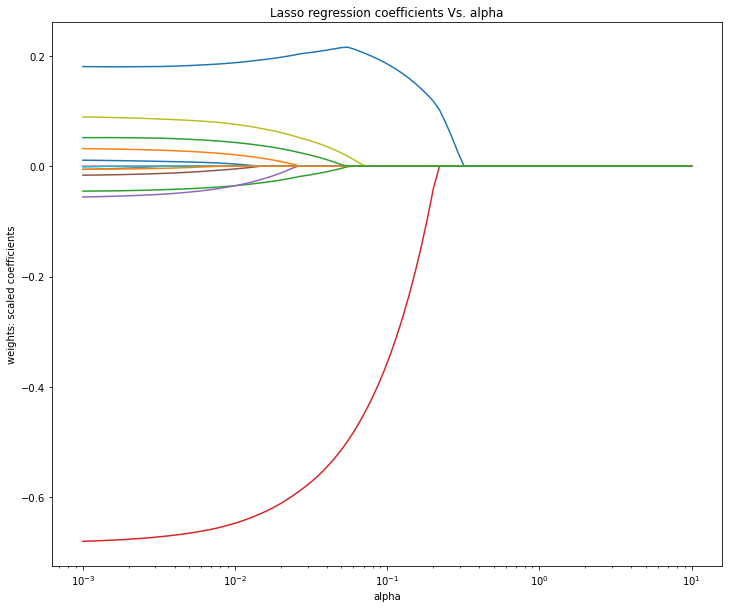

In [13]:
# 10. Apply Lasso regularization:
from sklearn.linear_model import Lasso

alpha_lasso = 10**np.linspace(-3,1,100)
lasso = Lasso()
coefs_lasso = []

for i in alpha_lasso:
    lasso.set_params(alpha = i)
    lasso.fit(X_train, y_train)
    coefs_lasso.append(lasso.coef_)
    
plt.figure(figsize=(12,10))
ax = plt.gca()
ax.plot(alpha_lasso, coefs_lasso)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights: scaled coefficients')
plt.title('Lasso regression coefficients Vs. alpha')
plt.show()

In [14]:
# 11. Set Lasso parameters and sort features by importance
lasso = Lasso(alpha=10**(-2))
model_lasso = lasso.fit(X_train, y_train)
coef = pd.Series(model_lasso.coef_,index=X_train.columns)
print(coef[coef != 0].abs().sort_values(ascending = False))

room_type                0.646959
neighbourhood_encoded    0.187534
availability_365         0.075919
group_range              0.042966
minimum_nights           0.035411
longitude                0.035335
latitude                 0.020619
number_of_reviews        0.004972
host_id                  0.003851
dtype: float64


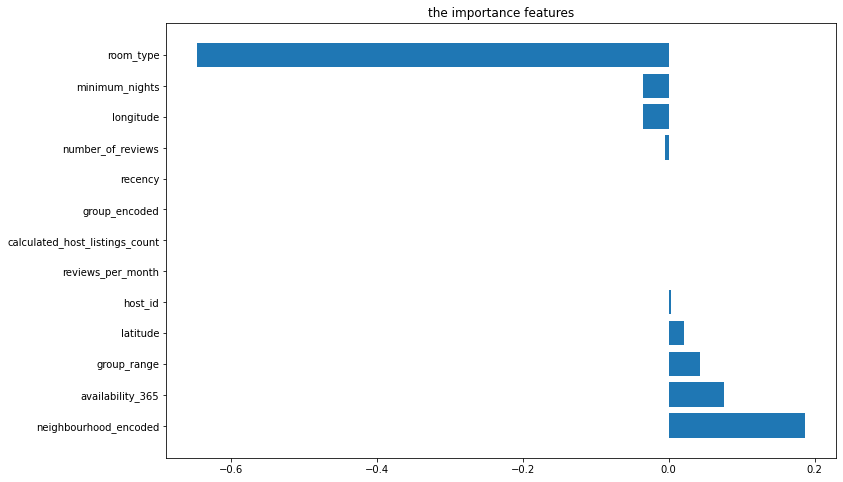

In [15]:
# 12. Display feature importance visually

fea = X_train.columns
a = pd.DataFrame()
a['feature'] = fea
a['importance'] = coef.values

a = a.sort_values('importance',ascending = False)
plt.figure(figsize=(12,8))
plt.barh(a['feature'],a['importance'])
plt.title('the importance features')
plt.show()

# Section 2: Modelling & Results

In [16]:
# 13. Train, Test, Split:
feature = coef[coef != 0].index.tolist()
dt = new_data[feature]

# Import train_test_split
from sklearn.model_selection import train_test_split

X = dt
y = new_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 666)

Model 1: Decision Tree Base Model

In [57]:
# 1. Import model from libraries
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=6,min_samples_leaf=0.12)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=0.12)

In [58]:
#2. Apply gridsearch to find optimal parameters
from sklearn.model_selection import GridSearchCV

pgrid = {"max_depth": [4,6,8,10],
          "min_samples_leaf": [ 0.12,0.14,0.16]}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)

In [59]:
# 3. Model Best Parameters:
best_rf = grid_search.best_estimator_
best_rf

DecisionTreeRegressor(max_depth=6, min_samples_leaf=0.12)

In [60]:
# 4. Calculate r2 Score:

from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.5201710197714251

Model 2: Random Forests

In [23]:
# 1.Import model from libraries
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, bootstrap=True)
random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [24]:
# 2. Apply Gridsearch to find optimal parameters
from sklearn.model_selection import GridSearchCV

pgrid = {"n_estimators": [100,200,300,400,500]}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)

In [26]:
# 3. Model Best Parameters:
best_rf = grid_search.best_estimator_
best_rf

RandomForestRegressor(n_estimators=500)

In [25]:
# 4. Calculate r2 Score:

from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.6244466009186525

Model 2(a): Random Forests without bootstrap but with GridSearch


In [29]:
# 1.Import model from libraries
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, bootstrap=False)
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False)

In [30]:
# 2. Apply Gridsearch to find optimal parameters
from sklearn.model_selection import GridSearchCV

pgrid = {"n_estimators": [400,500,600,700,800]}
grid_search = GridSearchCV(RandomForestRegressor(bootstrap=False), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)

In [31]:
# 3. Model Best Parameters:
best_rf = grid_search.best_estimator_
best_rf

RandomForestRegressor(bootstrap=False, n_estimators=600)

In [32]:
# 4. Calculate r2 Score:

from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.2992330880665449

Model 2(b): Random Forests with bootstrap and GridSearch

In [75]:
# 1. Import model from libraries
from sklearn.ensemble import RandomForestRegressor

random_forest2 = RandomForestRegressor(n_estimators=100, bootstrap=True)
random_forest2.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# 2. Apply Gridsearch to find optimal parameters
from sklearn.model_selection import GridSearchCV

pgrid = {"n_estimators": [600,700,800],
         "max_depth": [4,6,8,10,12,14]}
grid_search = GridSearchCV(RandomForestRegressor(bootstrap=True), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)

In [63]:
# 3. Model Best Parameters:
best_rf = grid_search.best_estimator_
best_rf

RandomForestRegressor(max_depth=10, n_estimators=600)

In [64]:
# 4. Calculate r2 Score:

from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.6184445323787567

Model 3(a): Extra Trees Regressor without Bootstrap and GridSearch

In [34]:
#  1. Import model from libraries
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor

regressor = ExtraTreesRegressor(n_estimators = 500, bootstrap=False, random_state = 0)
regressor.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=500, random_state=0)

In [35]:
# 2. Apply gridsearch to find optimal parameter for max_depth of ExtraTreesRegressor

from sklearn.model_selection import GridSearchCV

pgrid = {"max_depth": [4, 5, 6, 7, 8, 9, 10, 11, 12]}
grid_search = GridSearchCV(ExtraTreesRegressor(bootstrap=False), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)

In [36]:
# 3. Model Best Parameters:
best_rf = grid_search.best_estimator_
best_rf

ExtraTreesRegressor(max_depth=12)

In [37]:
# 4. Calculate r2 Score:

from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.6156554878377678

Model 3(b): Extra Trees Regressor with Bootstrap and GridSearch

In [38]:
#  1. Import model from libraries
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor

regressor = ExtraTreesRegressor(random_state = 0)
regressor.fit(X_train, y_train)

ExtraTreesRegressor(random_state=0)

In [42]:
# 2. Apply gridsearch to find optimal parameter for max_depth of ExtraTreesRegressor

from sklearn.model_selection import GridSearchCV

pgrid = {"max_depth": [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]}
grid_search = GridSearchCV(ExtraTreesRegressor(bootstrap=True), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)

In [43]:
# 3. Model Best Parameters:
best_rf = grid_search.best_estimator_
best_rf

ExtraTreesRegressor(bootstrap=True, max_depth=18)

In [44]:
# 4. Calculate r2 Score:

from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.6268798407633199

Model 4: XGBoost Regressor

In [45]:
# 1. Import model from libraries
from xgboost import XGBRegressor
model_reg = XGBRegressor(n_estimators=100, learning_rate=0.05, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

model_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [46]:
# 2. Apply gridsearch to find optimal parameter for max_depth of XGBoost
from sklearn.model_selection import GridSearchCV

pgrid = {"max_depth": [4, 6, 8, 10, 12, 14, 16, 18, 20]}
grid_search = GridSearchCV(XGBRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)

In [47]:
# 3. Model Best Parameters:
best_rf = grid_search.best_estimator_
best_rf

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [48]:
# 4. Calculate r2 Score:
from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.6218099447531837

Model 5: AdaBoostRegressor

In [49]:
# 1. Import model from libraries
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(n_estimators=100)
ada_reg.fit(X_train,y_train)

AdaBoostRegressor(n_estimators=100)

In [50]:
# 2. Apply gridsearch to find optimal parameter for max_depth of AdaBoost on n_estimators
from sklearn.model_selection import GridSearchCV

pgrid = {"n_estimators": [300,400,500,600,700]}
grid_search = GridSearchCV(AdaBoostRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)

In [51]:
# 3. Model Best Parameters:
best_rf = grid_search.best_estimator_
best_rf

AdaBoostRegressor(n_estimators=300)

In [52]:
# 4. Calculate r2_score
from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.23832272417715306

Model 6: CatBoost Regressor

In [66]:
import catboost as cb

In [67]:
# 2. Train model on training data
model = cb.CatBoostRegressor(loss_function='RMSE')
model.fit(X_train, y_train)

Learning rate set to 0.068992
0:	learn: 0.6391531	total: 5.71ms	remaining: 5.7s
1:	learn: 0.6173525	total: 10.9ms	remaining: 5.43s
2:	learn: 0.5975253	total: 15.5ms	remaining: 5.16s
3:	learn: 0.5801354	total: 20.1ms	remaining: 5s
4:	learn: 0.5643741	total: 24.7ms	remaining: 4.92s
5:	learn: 0.5502106	total: 29.3ms	remaining: 4.86s
6:	learn: 0.5373122	total: 33.7ms	remaining: 4.78s
7:	learn: 0.5254785	total: 37.9ms	remaining: 4.7s
8:	learn: 0.5151484	total: 42.2ms	remaining: 4.64s
9:	learn: 0.5057583	total: 46.3ms	remaining: 4.58s
10:	learn: 0.4971099	total: 51.2ms	remaining: 4.6s
11:	learn: 0.4897563	total: 57.1ms	remaining: 4.7s
12:	learn: 0.4833482	total: 61.7ms	remaining: 4.68s
13:	learn: 0.4771138	total: 66.4ms	remaining: 4.68s
14:	learn: 0.4718943	total: 71.7ms	remaining: 4.71s
15:	learn: 0.4670656	total: 76.1ms	remaining: 4.68s
16:	learn: 0.4627558	total: 80.9ms	remaining: 4.68s
17:	learn: 0.4588099	total: 85.3ms	remaining: 4.66s
18:	learn: 0.4554065	total: 90ms	remaining: 4.64s
1

In [69]:
# 3. Apply gridsearch to find optimal parameters

from catboost import CatBoostRegressor

pgrid = {"max_depth": [4,6,8,10]}
grid_search = GridSearchCV(CatBoostRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)

Streaming output truncated to the last 5000 lines.
4:	learn: 0.5624527	total: 95.1ms	remaining: 18.9s
5:	learn: 0.5473073	total: 115ms	remaining: 19s
6:	learn: 0.5339949	total: 136ms	remaining: 19.3s
7:	learn: 0.5215895	total: 156ms	remaining: 19.4s
8:	learn: 0.5109445	total: 176ms	remaining: 19.4s
9:	learn: 0.5010025	total: 196ms	remaining: 19.4s
10:	learn: 0.4916045	total: 225ms	remaining: 20.2s
11:	learn: 0.4836338	total: 246ms	remaining: 20.2s
12:	learn: 0.4764095	total: 266ms	remaining: 20.2s
13:	learn: 0.4700442	total: 287ms	remaining: 20.2s
14:	learn: 0.4643425	total: 308ms	remaining: 20.2s
15:	learn: 0.4589397	total: 328ms	remaining: 20.2s
16:	learn: 0.4540804	total: 348ms	remaining: 20.1s
17:	learn: 0.4497999	total: 368ms	remaining: 20.1s
18:	learn: 0.4458939	total: 388ms	remaining: 20.1s
19:	learn: 0.4424967	total: 409ms	remaining: 20s
20:	learn: 0.4393392	total: 435ms	remaining: 20.3s
21:	learn: 0.4365478	total: 462ms	remaining: 20.5s
22:	learn: 0.4339694	total: 483ms	remain

In [72]:
# 4. Model Best Parameters:
best_rf = grid_search.best_estimator_
print(best_rf)

In [71]:
# 5. Compute r2_score:
from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.632733708260193